In [4]:
%matplotlib inline

import numpy as np
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt

import glob

import subprocess
from subprocess import call

import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas

import pickle

In [5]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test.png', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew']
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
        
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    

In [6]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, name='test.png', linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
        
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

* transcripts with upstream translation ("RiboSET") and those without upstream translation (perhaps matched for CDS expression, which affects detectability of translation. So 392 trs/genes with no upstream translation and matched CDS coverage 
* same for top-5000 filtered genes 

# Metadata: tr_ids, genes, cds_start-stop, theoretical ext coo 

In [7]:
metadata_pc_g25 = pd.read_csv('../tmp_res/metadata_pc_g25.txt', sep='\t')
metadata_pc_g25[0:1]

,tr_id,gene,gene_tr,transcript_seq,5UTR_start_seq,CDS_start,cds_seq,cds_start_codon,cds_stop_codon,cds_start_pos,cds_stop_pos,utr5_start,utr5_end,record_id
0,ENST00000335137.3,OR4F5,OR4F5-001,ATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAAC...,NaN,ATG,ATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAAC...,ATG,TAG,0,918,0,0,ENST00000335137.3|ENSG00000186092.4|OTTHUMG000...


In [8]:
# open metadata with scores and metrics
meta = pd.read_csv('../tmp_res/local_and_global_df_g25ovlp_g35ovlp_g38ovlp_refseqovlp_strand_FRAMES_PhyloCSF.txt', sep='\t')
meta[0:1]

,tr_id,N_term_start,N_term_end,len,N_term_start1,N_term_end1,len_codons,gene,50len_flag,global_coo_50_and_less,...,max_sum_overlap_refseq_all_exons,max_sum_overlap_refseq_all_exons_strandless,ovlp,ovlp_strandless,ovlp2,ovlp2_strandless,PhyloCSF120score,tr_id1,number_of_records,records_names
0,ENST00000624431.1,274,316,42,274,316,14.0,FO538757.2,274,chr1:182667-182708,...,0,0,0;0;0,0;0;0,0;0;0;0,0;0;0;0,-163.9926,ENST00000624431,85,Human; Gorilla; Orangutan; Golden_snub_nosed_m...


# Get profiles for all transcripts; non-amb reads

In [9]:
!ls 

1_Transcripts_without_upstream_initiation.ipynb
2_extended_top_5000_RiboSET.ipynb
3_localisation_prediction_SignalP_TargetP_TMHMM_Phobius.ipynb
jupyters
plots
profiles
RiboSET_extended_top5000_filtered.txt
tmp_res


In [10]:
# get total list of transcripts 

amb_path = '../data/counts_ext/download/N_term_amb/*'
unamb_path = '../data/counts_ext/download/N_term_unamb/*'

list_of_tr = list(set([tr_path.split('/')[-1].split('_counts')[0] for tr_path in glob.glob(unamb_path)+glob.glob(amb_path)]))

list_of_amb_tr = [tr_path.split('/')[-1].split('_counts')[0] for tr_path in glob.glob(amb_path)]

list_of_unamb_tr = [tr_path.split('/')[-1].split('_counts')[0] for tr_path in glob.glob(unamb_path)]

print (list_of_tr[0:3])

print (len(list_of_tr), len(list_of_amb_tr), len(list_of_unamb_tr))

['ENST00000361361', 'ENST00000392127', 'ENST00000620401']
76910 75232 75139


# Get all ranked extensions (~10k)

In [11]:
transl_with_all_codons = pd.read_csv('../data/extensions_TripsViz_1perGene_AUG_NearCognates.txt', sep=',')

transl_with_all_codons.columns = ['gene_ext', 'tr_id1', 'Start_ext', 'Stop_ext', 'len_ext', 
                                 'global_rank_ext', 'type_all_codons', 'trips_viz_link', 'Start_codon_ext', 
                                 'Highframe rank', 'Highframe value',
       'Lowframe rank', 'Lowframe value', 'Stop rank', 'Stop value',
       'Start rank', 'Start value', 'Coverage rank', 'Coverage_value_ext',
       'Amino acid sequence', 'Proteomics_count_ext', 'CDS_ratio']

transl_with_all_codons2 = transl_with_all_codons[['gene_ext', 'tr_id1', 'Start_ext', 'Stop_ext', 
                                                 'global_rank_ext', 'Start_codon_ext', 
                                                 'Proteomics_count_ext', 'Coverage_value_ext', 'CDS_ratio']]

transl_with_all_codons2['Riboseq_Summary'] = transl_with_all_codons2['Start_codon_ext']+'; '+transl_with_all_codons2['Start_ext'].astype(str)+'-'+transl_with_all_codons2['Stop_ext'].astype(str)+'; Rank: '+transl_with_all_codons2['global_rank_ext'].astype(str)+'; cov: '+np.round(transl_with_all_codons2['Coverage_value_ext'],2).astype(str)


transl_with_all_codons2[0:5]

/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,gene_ext,tr_id1,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,CDS_ratio,Riboseq_Summary
0,ASPH,ENST00000379454,144,189,1,CTG,0.0,100.000000,1.645069,CTG; 144-189; Rank: 1; cov: 100.0
1,HSP90AA1,ENST00000216281,168,207,2,GTG,0.0,100.000000,3.081078,GTG; 168-207; Rank: 2; cov: 100.0
2,CD24,ENST00000619133,408,441,3,CTG,0.0,83.333333,11.578498,CTG; 408-441; Rank: 3; cov: 83.33
3,HN1,ENST00000409753,242,287,4,TTG,0.0,100.000000,0.588389,TTG; 242-287; Rank: 4; cov: 100.0
4,YBX1,ENST00000321358,44,140,5,CTG,0.0,85.185185,7.709763,CTG; 44-140; Rank: 5; cov: 85.19


## Unamb read counts for all genes 

In [12]:
# choose transcripts with no rank 

SEL_TR = list(set(list_of_tr) - set(transl_with_all_codons2[transl_with_all_codons2['Coverage_value_ext'] > 0]['tr_id1'].tolist()))

print (len(SEL_TR), len(list_of_tr))
print (SEL_TR[0:2])

72159 76910
['ENST00000357402', 'ENST00000541847']


In [14]:
metadata_pc_g25['tr_len'] = [len(x) for x in metadata_pc_g25['transcript_seq'].tolist()]

full_cds = [x.split('.')[0] for x in metadata_pc_g25[(metadata_pc_g25['cds_stop_pos'] < metadata_pc_g25['tr_len'])].tr_id.tolist()]


# length of theor ext is >=20 codons!!! 
SEL_TR_full_CDS = list(set(full_cds).intersection(SEL_TR).intersection(meta[(meta['len_codons'] >= 19)].tr_id1.tolist()))

len(SEL_TR_full_CDS)

25079

In [17]:
metadata_pc_g25[(metadata_pc_g25['cds_stop_pos'] < metadata_pc_g25['tr_len'])].tr_id.nunique(), len(full_cds)

(71241, 71241)

In [19]:
len(set(full_cds).intersection(SEL_TR))

53969

In [21]:
len(meta[(meta['len_codons'] >= 19)].tr_id1.unique())

39121

In [24]:
(134-179) / 3

-15.0

In [ ]:
# calcualte only 10k transcripts 

In [26]:
out_counts = {'amb':{}, 'unamb':{}, 'all':{}}

for i, tr_id in enumerate(SEL_TR_full_CDS):   
    
    if i % 1000 == 0:
        print ('transcript %s is processed out of 76910' % i)
    # end of transcript = its length
    tr_length = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq
    gene = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene

    if tr_id in list_of_unamb_tr:    
        tr_path_unamb = '../data/counts_ext/download/N_term_unamb/%s_counts.txt' % tr_id
        df_unamb = pd.read_csv(tr_path_unamb, sep='\t')
        d_unamb = dict(zip(df_unamb['pos'].tolist(), df_unamb['Total'].tolist()))
            
        for i in range(0, tr_length):
            if i not in d_unamb:
                d_unamb[i] = 0      
        out_counts['unamb'][tr_id] = d_unamb 
        
    else: # if tr_id is not in amb list
        continue
           
            
# save it to tmp_res            
with open('tmp_res/out_counts_25079_19codons.pickle', 'wb') as handle:
    pickle.dump(out_counts, handle, protocol=pickle.HIGHEST_PROTOCOL)

transcript 0 is processed out of 76910
transcript 1000 is processed out of 76910
transcript 2000 is processed out of 76910
transcript 3000 is processed out of 76910
transcript 4000 is processed out of 76910
transcript 5000 is processed out of 76910
transcript 6000 is processed out of 76910
transcript 7000 is processed out of 76910
transcript 8000 is processed out of 76910
transcript 9000 is processed out of 76910
transcript 10000 is processed out of 76910
transcript 11000 is processed out of 76910
transcript 12000 is processed out of 76910
transcript 13000 is processed out of 76910
transcript 14000 is processed out of 76910
transcript 15000 is processed out of 76910
transcript 16000 is processed out of 76910
transcript 17000 is processed out of 76910
transcript 18000 is processed out of 76910
transcript 19000 is processed out of 76910
transcript 20000 is processed out of 76910
transcript 21000 is processed out of 76910
transcript 22000 is processed out of 76910
transcript 23000 is proc

In [27]:
with open('tmp_res/out_counts_25079_19codons.pickle', 'rb') as handle:
    out_counts = pickle.load(handle)
print (len(out_counts['unamb'].keys()))

24619


# Counts per reading frame 

In [28]:
out_df_frames_un = {}

for i, tr_id in enumerate(list(out_counts['unamb'].keys())):
    
    if i % 1000 == 0:
        print (i)
        
    d = out_counts['unamb'][tr_id]
    # d = dict with positioons and counts 
    frames = {'Frame_1': {}, 'Frame_2': {}, 'Frame_3': {} }
    for pos, counts in d.items():
        if pos % 3 == 2:
            frames['Frame_1'][pos] = counts
        elif pos % 3 == 0:
            frames['Frame_2'][pos] = counts
        else:
            frames['Frame_3'][pos] = counts
    # make df 
    li1 = []
    li2 = []
    li3 = []
    
    # end of transcript = its length
    tr_length = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq
    gene = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
    
    for i in range(1, tr_length+1):
        if i in frames['Frame_1']:
            li1.append([i, int(frames['Frame_1'][i])])
        else:
            li1.append([i, int(0)])
    
    df1 = pd.DataFrame(li1, columns = ['Position', 'Frame 1']).sort_values(by='Position')
    
    for i in range(1, tr_length+1):
        if i in frames['Frame_2']:
            li2.append([i, int(frames['Frame_2'][i])])
        else:
            li2.append([i, int(0)])
    
    df2 = pd.DataFrame(li2, columns = ['Position', 'Frame 2']).sort_values(by='Position')
    
    for i in range(1, tr_length+1):
        if i in frames['Frame_3']:
            li3.append([i, int(frames['Frame_3'][i])])
        else:
            li3.append([i, int(0)])
    
    df3 = pd.DataFrame(li3, columns = ['Position', 'Frame 3']).sort_values(by='Position')
    
    df_f = df1.merge(df2, on='Position', how='inner').merge(df3, on='Position', how='inner')
    
    df_f['Sequence'] = list(tr_seq)
    
    df_f['Position'] = df_f['Position'] -1 #-3
    
    df_f['rna_seq'] = None
    
    df_f[['Position', 'Sequence', 'Frame 1', 'Frame 2', 'Frame 3', 'rna_seq']].to_csv('profiles/%s_%s_unamb.csv' % (gene, tr_id), index=False)

            
    out_df_frames_un[tr_id] = df_f
    
# save it out_df_frames_un 

with open('tmp_res/out_df_frames_25079_19codons.pickle', 'wb') as handle:
    pickle.dump(out_df_frames_un, handle, protocol=pickle.HIGHEST_PROTOCOL)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


# Iterate over 25079 profiles and get theoretical ext coverage, CDS peaks array and fraction of non-zero positions in ext  

In [29]:
li = []

for i,el in enumerate(list(out_df_frames_un.keys())):
    
    if i % 1000 == 0:
        print (i)
    N_term_start = meta[meta['tr_id'].str.contains(el)].iloc[0].N_term_start
    N_term_end = meta[meta['tr_id'].str.contains(el)].iloc[0].N_term_end
    
    cds_start = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(el)].iloc[0].cds_start_pos
    cds_stop = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(el)].iloc[0].cds_stop_pos 

    
    # get CDS frame and CDS array 
    if cds_start % 3 == 0:
        frame = 'Frame 1'        
    elif cds_start % 3 == 1:
        frame = 'Frame 2'        
    else:
        frame = 'Frame 3'
        
    # extract counts for that frame 
    counts = out_df_frames_un[el][['Position', frame]]
    
    # CDS_array and CDS_coverage per codon and nonzero pos fraction 
    CDS_array = counts[cds_start:cds_stop][frame].tolist() 
    CDS_coverage = np.sum(CDS_array) / ((cds_stop - cds_start)//3)
    CDS_nonzero_fraction = np.count_nonzero(CDS_array) / (len(CDS_array))
    
    #if frame == 'Frame 1':
    #    CDS_array1 = [CDS_array[i] for i in range(0, len(CDS_array), 3)]
    #elif frame == 'Frame 2':
    CDS_array1 = [CDS_array[i] for i in range(1, len(CDS_array), 3)]
    #else:
    #    CDS_array1 = [CDS_array[i] for i in range(2, len(CDS_array), 3)]
        
    
    theor_ext_array = counts[N_term_start:N_term_end][frame].tolist()
    NTE_coverage = np.sum(theor_ext_array) / ((N_term_end - N_term_start) // 3)
    NTE_nonzero_fraction = np.count_nonzero(theor_ext_array) / (len(theor_ext_array)) 
    
    
    CDS_std = np.std(CDS_array1)
    
    Z_score = (NTE_coverage - CDS_coverage) / CDS_std
    
    
    
    li.append([el, Z_score, 
               CDS_coverage, NTE_coverage, 
               CDS_nonzero_fraction, NTE_nonzero_fraction,
              ])
    
    
df = pd.DataFrame(li, columns = ['tr_id', 'Z_score', 
               'CDS_coverage', 'NTE_coverage', 
               'CDS_nonzero_fraction', 'NTE_nonzero_fraction'])


df.to_csv('tmp_res/25079_19codons_UPD_trs_coverages.txt', sep='\t', index=False)

0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


In [30]:
df = pd.read_csv('tmp_res/25079_19codons_UPD_trs_coverages.txt', sep='\t')

df

,tr_id,Z_score,CDS_coverage,NTE_coverage,CDS_nonzero_fraction,NTE_nonzero_fraction
0,ENST00000532161,-0.278238,442.735537,309.680556,0.333333,0.240741
1,ENST00000445327,-0.607791,4.629496,0.000000,0.241007,0.000000
2,ENST00000469435,-0.567311,56.652482,15.968750,0.276596,0.229167
3,ENST00000598259,-0.512322,5.623188,0.173913,0.207729,0.043478
4,ENST00000586133,0.072108,0.559322,0.703704,0.045198,0.074074
...,...,...,...,...,...,...
24614,ENST00000429644,-0.603927,61.583215,13.409091,0.332385,0.166667
24615,ENST00000376463,-0.085079,2.137931,0.846154,0.062069,0.064103
24616,ENST00000535543,-0.098383,0.816176,0.125000,0.039216,0.025000
24617,ENST00000557957,-0.399779,7.147757,2.238806,0.292436,0.078818


In [16]:
df3 = pd.concat([df, df2])

In [1]:
df3.sort_values(by='Z_score')

NameError: name 'df3' is not defined

In [18]:
df3.to_csv('tmp_res/0k_30k_UPD_TOTAL_trs_coverages.txt', sep='\t', index=False)

* fraction of covered by footprints position in theoretical ext is less than 10%
* theoretical ext coverage is less than 0.1
* CDS-cov is matched to CDS cov in RiboSET, RiboSET_ext 

In [20]:
df3[(df3['NTE_nonzero_fraction'] < 0.1) & 
   (df3['NTE_coverage'] < 0.1) & 
   (df3['CDS_coverage'] > 0)].sort_values(by='NTE_coverage')

,tr_id,Z_score,CDS_coverage,NTE_coverage,CDS_nonzero_fraction,NTE_nonzero_fraction
0,ENST00000368601,-0.774862,8.110092,0.000000,0.281346,0.000000
4427,ENST00000542254,-0.281106,1.435897,0.000000,0.068376,0.000000
4418,ENST00000337990,-1.039318,31.698020,0.000000,0.330033,0.000000
4417,ENST00000509503,-0.824429,53.851485,0.000000,0.326733,0.000000
4405,ENST00000421016,-0.275129,6.643678,0.000000,0.058110,0.000000
...,...,...,...,...,...,...
11732,ENST00000506536,-0.403173,4.655963,0.096774,0.133028,0.032258
14484,ENST00000525361,-0.527028,14.189944,0.097561,0.294227,0.024390
8647,ENST00000262843,-0.584287,1.788043,0.097561,0.214221,0.016260
251,ENST00000535628,-0.270054,0.440323,0.097561,0.077957,0.016173


TMEM40 ENST00000264728
---
False
84
0


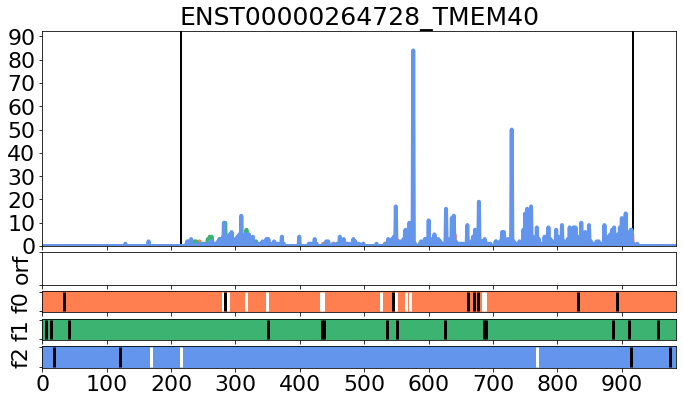

In [141]:
tr_id = 'ENST00000264728'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene

print (gene, tr_id)

#pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
#pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
#pre_st = pos_pred_start + '_' + pred_start

pre_st = False 

print ('---')

print (pre_st)

xlims = 'full'

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 100, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name='SLC19A2.png', font1=22, font2=25)

ATOX1 ENST00000522314
---
False
1999
0


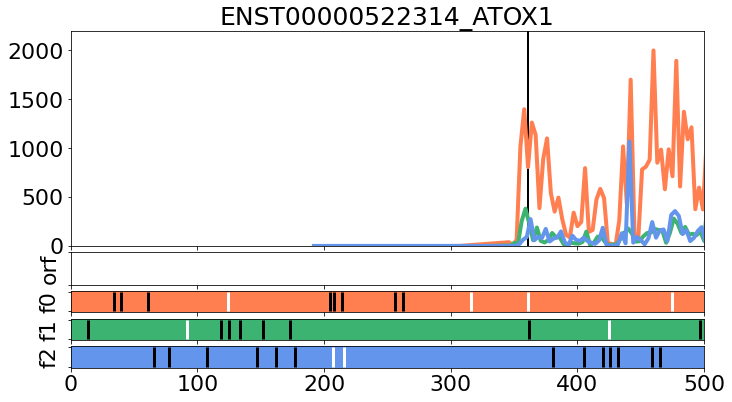

In [133]:
tr_id = 'ENST00000522314'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene

print (gene, tr_id)

#pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
#pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
#pre_st = pos_pred_start + '_' + pred_start

pre_st = False 

print ('---')

print (pre_st)

xlims = [0, 500]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq = 100, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SLC19A2.png', font1=22, font2=25)

MRPL28 ENST00000389675
---
False
2615
0


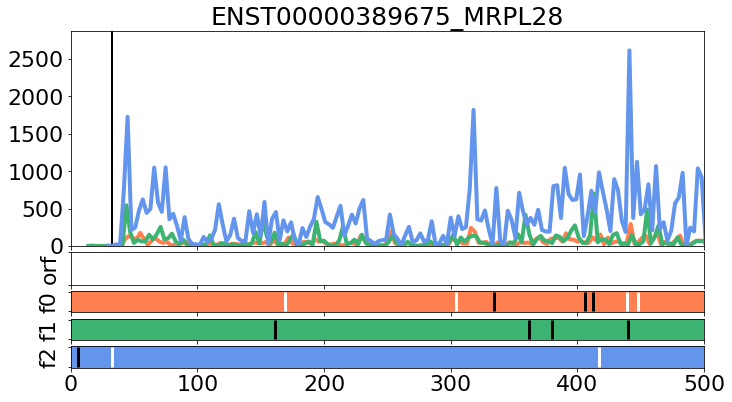

In [124]:
tr_id = 'ENST00000389675'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene

print (gene, tr_id)

#pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
#pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
#pre_st = pos_pred_start + '_' + pred_start

pre_st = False 

print ('---')

print (pre_st)

xlims = [0, 500]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq = 100, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SLC19A2.png', font1=22, font2=25)

ZNF217 ENST00000302342
---
False
461
0


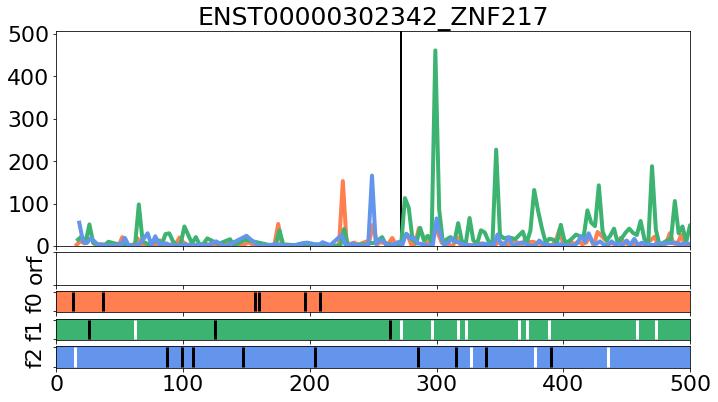

In [122]:
tr_id = 'ENST00000302342'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene

print (gene, tr_id)

#pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
#pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
#pre_st = pos_pred_start + '_' + pred_start

pre_st = False 

print ('---')

print (pre_st)

xlims = [0, 500]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 100, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SLC19A2.png', font1=22, font2=25)

VAT1 ENST00000420567
---
False
2567
0


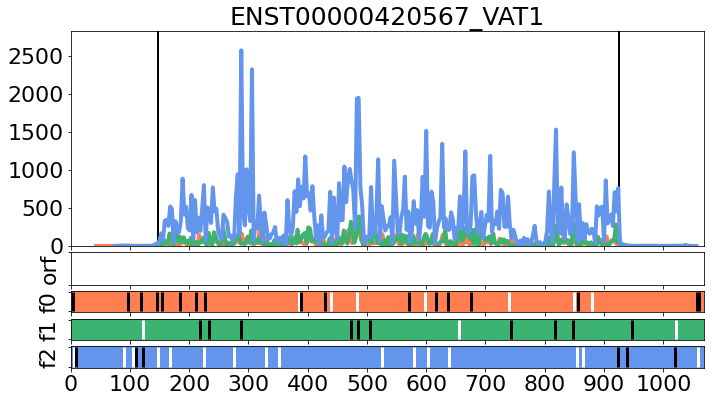

In [117]:
tr_id = 'ENST00000420567'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene

print (gene, tr_id)

#pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
#pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
#pre_st = pos_pred_start + '_' + pred_start

pre_st = False 

print ('---')

print (pre_st)

xlims = 'full' #[R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-50, 
         #metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+200*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq = 100, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SLC19A2.png', font1=22, font2=25)

CREB3L4 ENST00000368601
---
False
94
0


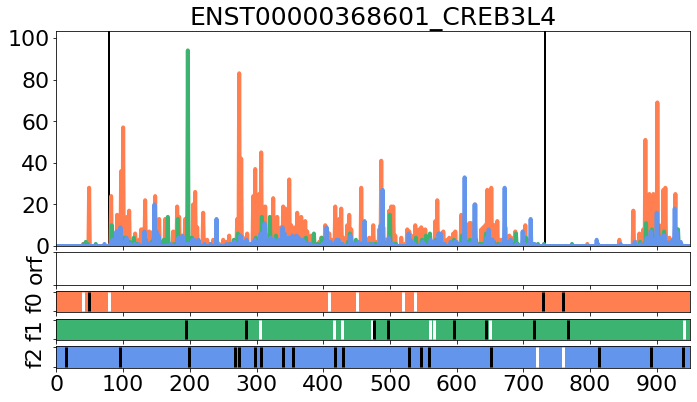

In [67]:
tr_id = 'ENST00000368601'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene

print (gene, tr_id)

#pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
#pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
#pre_st = pos_pred_start + '_' + pred_start

pre_st = False 

print ('---')

print (pre_st)

xlims = 'full' #[R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-50, 
         #metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+200*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq = 100, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name='SLC19A2.png', font1=22, font2=25)

# Select no-upstream-translation + CDS min-max match to top-5000